## Compare different losses and test tasks

In [1]:
%load_ext autoreload
%autoreload 2
from transformer_lens import HookedTransformer, ActivationCache
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import pickle

from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform

from tqdm.auto import tqdm

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_type = "gemma-7b"

if model_type == "pythia":
    reference_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8B").cuda()
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8B")
    tokenizer.pad_token_id = tokenizer.eos_token_id
# elif model_type == "llama":
    
elif model_type == "gemma-2b":
    reference_model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", torch_dtype=torch.bfloat16).cuda()
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "right"

elif model_type == "qwen":
    reference_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-4B", torch_dtype=torch.bfloat16).cuda()
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-4B")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "right"

elif model_type == "gemma-7b":
    reference_model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16).cuda()
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "right"
# elif model_type == "qwen"

elif model_type == "llama-2":
    reference_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf").cuda()
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "right"

else:
    reference_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Memory usage: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory usage: 16.40 GB


## Train with different losses

In [3]:
sports_forget_athletes = SportsTask(batch_size=32, tokenizer=tokenizer, forget_sport_subset=None, forget_player_subset=32, is_forget_dataset=True, train_test_split=False)
sports_remaining_athletes = SportsTask(batch_size=32, tokenizer=tokenizer, forget_sport_subset=None, 
forget_player_subset=32, is_forget_dataset=False)

In [4]:
print(len(sports_forget_athletes.train_df))
print(len(sports_forget_athletes.test_df))
print(len(sports_remaining_athletes.train_df))
print(len(sports_remaining_athletes.test_df))

32
32
1227
307


In [5]:
# compare Gradient Ascent (-IOITask[CE] + OWT), HarmBench Loss (IOITask[1MP] + OWT), NPO Loss (IOITask_NPO), NPO+SFT Loss (IOITask_NPO + OWT), Uniform_all Loss (IOITask_Uniform[all_tokens] + OWT), Uniform_exclude Loss (IOITask_Uniform[exclude_correct] + OWT)
device = "cuda"
train_loss_type = "sports"
forget_athletes = 32
forget_sport=None
# forget_sport = "basketball"
# maintain_sport = "football"
maintain_sport = None
# val_sport = "baseball"

forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}

if model_type == "pythia" or model_type == "gemma-7b" or model_type == "gemma-2b" or model_type == "llama-2" or model_type == "qwen":
    if train_loss_type == "sports":
        if model_type == "pythia" or model_type == "gemma-2b" or model_type == "qwen":
            train_batch_size = 8
        else:
            train_batch_size = 24
        sports_ce = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
        sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)
        sports_npo = SportsTask_NPO(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, ref_model=reference_model, beta=1, **forget_kwargs)
        sports_uniform_all = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="all_tokens", exclude_correct=False, **forget_kwargs)
        sports_uniform_sports = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="sports_tokens", exclude_correct=False, **forget_kwargs)
        sports_uniform_sports_golf = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="sports_with_golf", exclude_correct=False, **forget_kwargs)

        if maintain_sport is None:
            maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
        else:
            maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
        
        train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

        if model_type == "pythia" or model_type == "gemma-2b" or model_type == "qwen":
            eval_batch_size=64
        else:
            eval_batch_size=32
        # want to eval on other sports
        forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
        test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

        induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
        if maintain_sport is None:
            maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
            eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
        else:
            maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
            val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
            eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}


else:
    batch_size = 80

    if train_loss_type == "ioi":
        ioi_ce = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="cross_entropy")
        ioi_1mp = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="log_1_minus_p")
        ioi_npo = IOITask_NPO(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", ref_model=reference_gpt2, beta=1)
        ioi_uniform = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=False)
        ioi_uniform_exclude = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=True)
        ioi_uniform_specific = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="IO_S", nb_templates=4, prompt_type="ABBA", exclude_correct=False)

    elif train_loss_type == "induction":
        induction_ce = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="cross_entropy")
        induction_1mp = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="log_1_minus_p")
        induction_npo = InductionTask_NPO(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="npo", ref_model=reference_gpt2, beta=1)
        induction_uniform = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", exclude_correct=False)
        induction_uniform_exclude = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", exclude_correct=True)
        induction_uniform_specific = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="rep_tokens", exclude_correct=False)
        induction_uniform_specific_exclude = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="rep_tokens", exclude_correct=True)

    owt = OWTTask(batch_size=batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

    eval_batch_size=160
    greaterthan_eval = GreaterThanTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device)
    ioi_eval = IOITask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA")
    induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
    eval_tasks = {"ioi": ioi_eval, "induction": induction_eval, "owt": owt, "greaterthan": greaterthan_eval}

print(f"Memory usage: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Memory usage: 16.40 GB


## Test ioi_1mp

In [6]:
print(f"{len(sports_1mp.train_dataset)}, {len(sports_1mp.test_dataset)}")
print(f"{len(sports_npo.train_dataset)}, {len(sports_npo.test_dataset)}")

print(f"{len(forget_sport_eval.train_dataset)}, {len(forget_sport_eval.test_dataset)}")

if maintain_sport is None:
    print(f"{len(maintain_sports_eval.train_dataset)}, {len(maintain_sports_eval.test_dataset)}")
else:
    print(f"{len(maintain_sport_eval.train_dataset)}, {len(maintain_sport_eval.test_dataset)}")
    print(f"{len(val_sport_eval.train_dataset)}, {len(val_sport_eval.test_dataset)}")

32, 32
32, 32
32, 32
1227, 307


In [7]:
print(tokenizer([" basketball", " football", " baseball", "basketball", "football", "baseball"]))
print(tokenizer([" Basketball", " Football", " Baseball"]))

{'input_ids': [[2, 21474], [2, 9715], [2, 23052], [2, 120585], [2, 43563], [2, 111021]], 'attention_mask': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]}
{'input_ids': [[2, 48674], [2, 20758], [2, 51531]], 'attention_mask': [[1, 1], [1, 1], [1, 1]]}


In [8]:
continuous_accuracy = True
print(f"Running on {model_type}")
# if model_type == "pythia" or model_type == "gemma-7b" or model_type == "gemma-2b":
if train_loss_type == "sports":
    print(f"Sports 1MP Test Loss: {sports_1mp.get_test_loss(reference_model)}")
    print(f"Sports NPO Test Loss: {sports_npo.get_test_loss(reference_model)}")
    print(f"Sports Uniform All Test Loss: {sports_uniform_all.get_test_loss(reference_model)}")
    print(f"Sports Uniform Sports Test Loss: {sports_uniform_sports.get_test_loss(reference_model)}")
    print(f"Sports Uniform Sports Golf Test Loss: {sports_uniform_sports_golf.get_test_loss(reference_model)}")
    print(f"Maintain Sports Test Loss: {maintain_sports.get_test_loss(reference_model)}")
    
    print(f"Forget Sport Eval Test Loss: {forget_sport_eval.get_test_loss(reference_model)}")
    print(f"Forget Sport Eval Test Accuracy: {forget_sport_eval.get_test_accuracy(reference_model, continuous=continuous_accuracy)}")
    if maintain_sport is None:
        print(f"Maintain Sports Eval Test Loss: {maintain_sports_eval.get_test_loss(reference_model)}")
        print(f"Maintain Sports Eval Test Accuracy: {maintain_sports_eval.get_test_accuracy(reference_model, continuous=continuous_accuracy)}")
    else:
        print(f"Maintain Sport Eval Test Loss: {maintain_sport_eval.get_test_loss(reference_model)}")
        print(f"Maintain Sport Eval Test Accuracy: {maintain_sport_eval.get_test_accuracy(reference_model, continuous=continuous_accuracy)}")
        print(f"Val Sport Eval Test Loss: {val_sport_eval.get_test_loss(reference_model)}")
        print(f"Val Sport Eval Test Accuracy: {val_sport_eval.get_test_accuracy(reference_model, continuous=continuous_accuracy)}")

    print(f"Test Pile Test Loss: {test_pile.get_test_loss(reference_model)}")

else:
    test_model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    if train_loss_type == "ioi":
        print(f"IOI Eval Test Loss: {ioi_eval.get_test_loss(test_model)}")
        print(f"IOI 1MP Test Loss: {ioi_1mp.get_test_loss(test_model)}")
        print(f"IOI NPO Test Loss: {ioi_npo.get_test_loss(test_model)}")

Running on gemma-7b
Sports 1MP Test Loss: 2.3229167461395264
Sports NPO Test Loss: 1.3828125
Sports Uniform All Test Loss: 23.375
Sports Uniform Sports Test Loss: 4.65625
Sports Uniform Sports Golf Test Loss: 4.9375
Maintain Sports Test Loss: 0.2578125
Forget Sport Eval Test Loss: 0.154296875
Forget Sport Eval Test Accuracy: 0.9921875
Maintain Sports Eval Test Loss: 0.1142578125
Maintain Sports Eval Test Accuracy: 0.99609375
Test Pile Test Loss: 2.515625


In [9]:
sports_normal = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer)
accuracy = 0
for i in range(5):
    accuracy += sports_normal.get_test_accuracy(reference_model, continuous=continuous_accuracy)
print(f"Sports Normal Test Accuracy: {accuracy / 5}")

Sports Normal Test Accuracy: 0.97421875


## Train Models

In [10]:
from cb_utils.learn_mask import evaluate_model
def train_loop(model, optimizer, num_epochs, train_tasks, train_task_weights, eval_tasks, eval_every=1, num_steps_per_epoch=100, eval_iters=4, grad_accum_steps=1):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        for step in range(num_steps_per_epoch):
            optimizer.zero_grad()
            train_loss = {}
            for task_name in train_tasks:
                # print(f"On task_name: {task_name}")
                task = train_tasks[task_name]
                train_loss[task_name] = 0
                for _ in range(grad_accum_steps):
                    task_weight = train_task_weights[task_name]
                    loss = task.get_train_loss(model)
                    train_loss[task_name] += loss.item() / grad_accum_steps
                    loss = loss * task_weight / grad_accum_steps
                    loss.backward()
            # print(f"Current memory before step: {torch.cuda.memory_allocated() / 1024**3}, Max memory: {torch.cuda.max_memory_allocated() / 1024**3}")
            optimizer.step()
            # print(f"Current memory after step: {torch.cuda.memory_allocated() / 1024**3}, Max memory: {torch.cuda.max_memory_allocated() / 1024**3}")
            train_losses.append(train_loss)

        if epoch % eval_every == 0:
            test_loss = evaluate_model(model, eval_tasks, num_eval_steps=eval_iters)
            test_losses.append(test_loss)
    return train_losses, test_losses

Using device: cuda:0


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# optional: use loras
from peft import get_peft_model, LoraConfig, TaskType

def create_peft_config(model, rank=64):

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=rank,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules = "all-linear", #["q_proj", "v_proj", 
    )

    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config

In [12]:
num_epochs = 20
steps_per_epoch = 10
lr = 1e-4
wd = 0
grad_accum_steps = 160 / train_batch_size
use_lora = True
lora_rank = 128
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval

# if use_pythia:
if train_loss_type == "sports":
    loss_types = {
        # "Cross Entropy": ({'sports_ce': sports_ce, 'pile': train_pile}, {'sports_ce': -.2, 'pile': 1}),
        # "Log 1 Minus P": ({'sports_1mp': sports_1mp, 'pile': train_pile}, {'sports_1mp': .2, 'pile': 1}),
        # "NPO_SFT": ({'sports_npo': sports_npo, 'pile': train_pile}, {'sports_npo': .2, 'pile': 1}),
        # "Uniform All": ({'sports_uniform_all': sports_uniform_all, 'pile': train_pile}, {'sports_uniform_all': .2, 'pile': 1}),
        # "Uniform Sports": ({'sports_uniform_sports': sports_uniform_sports, 'pile': train_pile}, {'sports_uniform_sports': .2, 'pile': 1}),
        # "Uniform Sports Golf": ({'sports_uniform_sports_golf': sports_uniform_sports_golf, 'pile': train_pile}, {'sports_uniform_sports_golf': .2, 'pile': 1}),

        "Cross Entropy with Maintain": ({'sports_ce': sports_ce, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_ce': -.2, 'maintain_sports': 1, 'pile': 1}),
        "Log 1 Minus P with Maintain": ({'sports_1mp': sports_1mp, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_1mp': .2, 'maintain_sports': 1, 'pile': 1}),
        # "NPO_SFT with Maintain": ({'sports_npo': sports_npo, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_npo': .2, 'maintain_sports': 1, 'pile': 1}),
        "Uniform All with Maintain": ({'sports_uniform_all': sports_uniform_all, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_all': .2, 'maintain_sports': 1, 'pile': 1}),
        "Uniform Sports with Maintain": ({'sports_uniform_sports': sports_uniform_sports, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_sports': .2, 'maintain_sports': 1, 'pile': 1}),
        "Uniform Sports Golf with Maintain": ({'sports_uniform_sports_golf': sports_uniform_sports_golf, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_sports_golf': .2, 'maintain_sports': 1, 'pile': 1}),
    }

else:
    if train_loss_type == "ioi":
        loss_types = {
            "Cross Entropy": ({'ioi': ioi_ce, 'owt': owt}, {'ioi': -.2, 'owt': 1}), 
            "Log 1 Minus P": ({'ioi_1mp': ioi_1mp, 'owt': owt}, {'ioi_1mp': .2, 'owt': 1}), 
            "NPO": ({'ioi_npo': ioi_npo}, {'ioi_npo': .2}), 
            "NPO SFT": ({'ioi_npo': ioi_npo, 'owt': owt}, {'ioi_npo': .2, 'owt': 1}), 
            "Uniform Over All": ({'ioi_uniform': ioi_uniform, 'owt': owt}, {'ioi_uniform': .2, 'owt': 1}), 
            "Uniform Excluding Correct": ({'ioi_uniform_exclude': ioi_uniform_exclude, 'owt': owt}, {'ioi_uniform_exclude': .2, 'owt': 1}), 
            "Uniform Over Specific": ({'ioi_uniform_specific': ioi_uniform_specific, 'owt': owt}, {'ioi_uniform_specific': .2, 'owt': 1}),
        }
    elif train_loss_type == "induction":
        loss_types = {
            "Cross Entropy": ({'induction_ce': induction_ce, 'owt': owt}, {'induction_ce': -.2, 'owt': 1}), 
            "Log 1 Minus P": ({'induction_1mp': induction_1mp, 'owt': owt}, {'induction_1mp': .2, 'owt': 1}), 
            "NPO": ({'induction_npo': induction_npo}, {'induction_npo': .2}), 
            "NPO SFT": ({'induction_npo': induction_npo, 'owt': owt}, {'induction_npo': .2, 'owt': 1}), 
            "Uniform Over All": ({'induction_uniform': induction_uniform, 'owt': owt}, {'induction_uniform': .2, 'owt': 1}), 
            "Uniform Excluding Correct": ({'induction_uniform_exclude': induction_uniform_exclude, 'owt': owt}, {'induction_uniform_exclude': .2, 'owt': 1}), 
            "Uniform Over Specific": ({'induction_uniform_specific': induction_uniform_specific, 'owt': owt}, {'induction_uniform_specific': .2, 'owt': 1}),
            "Uniform Over Specific Excluding Correct": ({'induction_uniform_specific_exclude': induction_uniform_specific_exclude, 'owt': owt}, {'induction_uniform_specific_exclude': .2, 'owt': 1}),
        }

all_train_losses = {}
all_test_losses = {}
adversarial_evals = {}
for loss_name in tqdm(loss_types):
    if "NPO" in loss_name:
        reference_model.cuda()
    else:
        reference_model.cpu()
    train_tasks, task_weights = loss_types[loss_name]
    if model_type == "pythia":
        model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8B")
    elif model_type == "gemma-7b":
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
    elif model_type == "gemma-2b":
        model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", torch_dtype=torch.bfloat16)
    elif model_type == "qwen":
        model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-4B", torch_dtype=torch.bfloat16)
    else:
        model = AutoModelForCausalLM.from_pretrained("gpt2")
    if use_lora:
        model, _ = create_peft_config(model, rank=lora_rank)
    model.cuda()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    print(f"Before train loop, memory usage: {torch.cuda.memory_allocated() / 1e9} GB, max memory usage: {torch.cuda.max_memory_allocated() / 1e9} GB")
    train_losses, test_losses = train_loop(model, optimizer, num_epochs, train_tasks, task_weights, eval_tasks, num_steps_per_epoch=steps_per_epoch)
    print(torch.cuda.max_memory_allocated() / 1024**3)
    all_train_losses[loss_name] = train_losses
    all_test_losses[loss_name] = test_losses

    if train_loss_type == "sports":
        adversarial_evals[loss_name] = (adversarial_sports_eval(model, model_type, batch_size=eval_batch_size, continuous=True))

    model.cpu()
    del model

if train_loss_type == "sports":
    if forget_sport is not None:
        with open(f"results/{model_type=}_{train_loss_type}_{forget_sport=}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
            pickle.dump((all_train_losses, all_test_losses, adversarial_evals), f)
    elif forget_athletes is not None:
        with open(f"results/{model_type=}_{train_loss_type}_{forget_athletes=}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
            pickle.dump((all_train_losses, all_test_losses, adversarial_evals), f)
    # with open(f"results/{model_type=}_{train_loss_type}_{forget_sport}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
else:
    with open(f"results/{model_type=}_{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
        pickle.dump((all_train_losses, all_test_losses), f)

  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 400,031,744 || all params: 8,937,712,640 || trainable%: 4.475773166052472
Before train loop, memory usage: 18.93116416 GB, max memory usage: 39.115094016 GB


  0%|          | 0/20 [00:00<?, ?it/s]

46.76956653594971


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 400,031,744 || all params: 8,937,712,640 || trainable%: 4.475773166052472
Before train loop, memory usage: 18.93974528 GB, max memory usage: 50.21843968 GB


  0%|          | 0/20 [00:00<?, ?it/s]

46.77047824859619


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 400,031,744 || all params: 8,937,712,640 || trainable%: 4.475773166052472
Before train loop, memory usage: 18.93980672 GB, max memory usage: 50.219418624 GB


  0%|          | 0/20 [00:00<?, ?it/s]

46.77047824859619


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 400,031,744 || all params: 8,937,712,640 || trainable%: 4.475773166052472
Before train loop, memory usage: 18.940798976 GB, max memory usage: 50.219418624 GB


  0%|          | 0/20 [00:00<?, ?it/s]

46.77060508728027


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 400,031,744 || all params: 8,937,712,640 || trainable%: 4.475773166052472
Before train loop, memory usage: 18.940716032 GB, max memory usage: 50.219554816 GB


  0%|          | 0/20 [00:00<?, ?it/s]

46.772725105285645


In [13]:
for loss_name in all_test_losses:
    print(f"Loss Name: {loss_name}")
    # test_losses = all_test_losses[loss_name]
    # for i, test_loss in enumerate(test_losses):
    #     print(f"Epoch {i}: {test_loss}")

    if train_loss_type == "sports":
        adversarial_eval = adversarial_evals[loss_name]
        print(f"Adversarial Eval: {adversarial_eval}")
    print("\n\n")

Loss Name: Cross Entropy with Maintain
Adversarial Eval: {'Normal': {'football': 0.530078125, 'baseball': 0.621875, 'basketball': 0.48281250000000003}, 'MC': {'football': 0.7429687500000001, 'baseball': 0.011181640625, 'basketball': 0.23828125}, 'Capitalized': {'football': 0.5578125, 'baseball': 0.511328125, 'basketball': 0.509375}, 'Dashed': {'football': 0.6166875481605529, 'baseball': 0.4169911742210388, 'basketball': 0.014280139654874803}}



Loss Name: Log 1 Minus P with Maintain
Adversarial Eval: {'Normal': {'football': 0.99921875, 'baseball': 0.9945312500000001, 'basketball': 0.96875}, 'MC': {'football': 0.49921875000000004, 'baseball': 0.2029296875, 'basketball': 0.2427734375}, 'Capitalized': {'football': 1.0, 'baseball': 0.99140625, 'basketball': 0.9679687499999998}, 'Dashed': {'football': 0.39265127182006837, 'baseball': 0.8407593011856079, 'basketball': 0.02690345151349902}}



Loss Name: Uniform All with Maintain
Adversarial Eval: {'Normal': {'football': 1.0, 'baseball': 0.9

In [14]:
adversarial_evals["Log 1 Minus P with Maintain"]

{'Normal': {'football': 0.99921875,
  'baseball': 0.9945312500000001,
  'basketball': 0.96875},
 'MC': {'football': 0.49921875000000004,
  'baseball': 0.2029296875,
  'basketball': 0.2427734375},
 'Capitalized': {'football': 1.0,
  'baseball': 0.99140625,
  'basketball': 0.9679687499999998},
 'Dashed': {'football': 0.39265127182006837,
  'baseball': 0.8407593011856079,
  'basketball': 0.02690345151349902}}

In [15]:
# if use_lora:
#     model.save_pretrained(f"results/{model_type}_{forget_sport=}_{maintain_sport=}_Lora{lora_rank}_Log_1MP")
# else:
#     model.save_pretrained(f"results/{model_type}_{forget_sport=}_{maintain_sport=}_Log_1MP")

In [27]:
# model = AutoModelForCausalLM.from_pretrained(f"results/{model_type}_Sports_{forget_sport=}_Log_1MP_with_Maintain_Football", torch_dtype=torch.bfloat16).cuda()
hf_name = f"PhillipGuo/{model_type}_Unlearning_{forget_sport}"
if maintain_sport is not None:
    hf_name += f"_Maintain_{maintain_sport}"
if use_lora:
    hf_name += f"_Lora{lora_rank}"
model.push_to_hub(hf_name)



model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.91G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PhillipGuo/qwen_Unlearning_basketball/commit/8335eb06ba8d6dbe3bd0f3543df92fd1ed5514ec', commit_message='Upload Qwen2ForCausalLM', commit_description='', oid='8335eb06ba8d6dbe3bd0f3543df92fd1ed5514ec', pr_url=None, pr_revision=None, pr_num=None)

## Analyze Losses - Pythia

In [16]:
import matplotlib.pyplot as plt

def plot_train_metric(loss_type, loss_name_filter=None):
    plt.figure(figsize=(12, 8))
    for loss_name in all_train_losses:
        if loss_name_filter is not None and loss_name_filter(loss_name) is False:
            continue
        plt.plot([x[loss_type] for x in all_train_losses[loss_name]], label=f"{loss_name} - {loss_type}")
    plt.title(f"Train {loss_type} Losses with Learning Rate {lr}")
    plt.xlabel("Step")
    plt.ylabel(f"{loss_type} Loss")
    plt.legend()

def plot_test_metric(loss_type, loss_name_filter=None):
    plt.figure(figsize=(12, 8))
    for loss_name in all_test_losses:
        if loss_name_filter is not None and loss_name_filter(loss_name) is False:
            continue
        # print(loss_name, all_test_losses[loss_name])
        # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
    plt.legend()

    plt.title(f"Test {loss_type}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{loss_type}")
    # only plot y range from 0 to 3
    # plt.ylim(-.1, 1.1)

def graph_accuracies(loss_name, include_val=False):

    plt.figure(figsize=(12, 8))
    loss_types = ["forget_sport_acc", "maintain_sport_acc"]
    if include_val:
        loss_types.append("val_sport_acc")

    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            if loss_type not in x:
                continue
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_type}")
    plt.legend()
    plt.title(f"Test Accuracies for {loss_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 

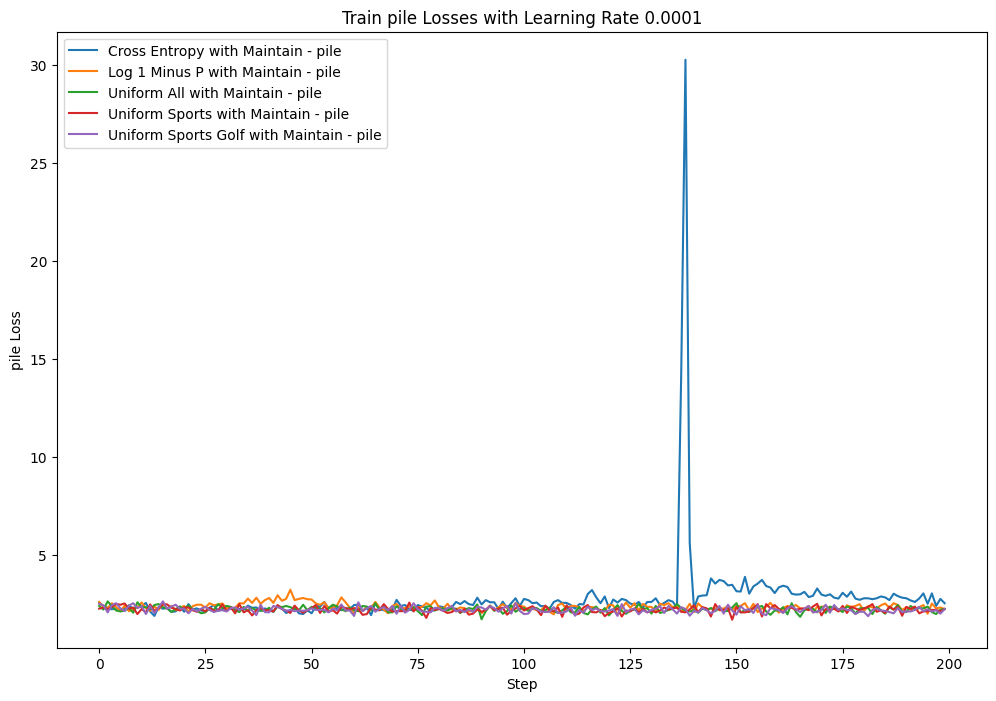

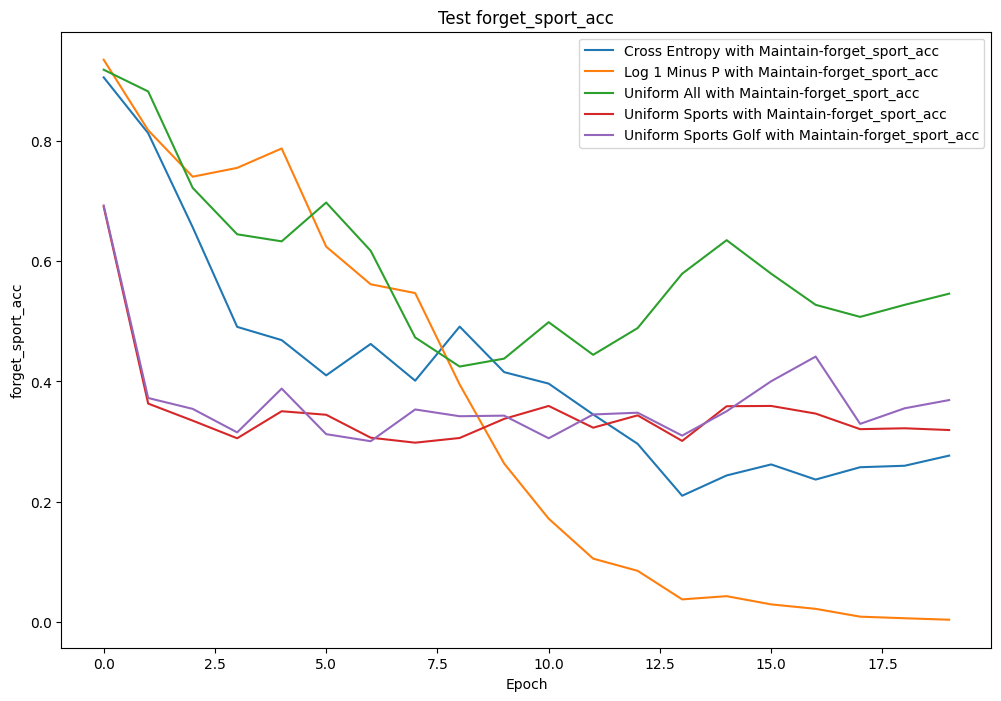

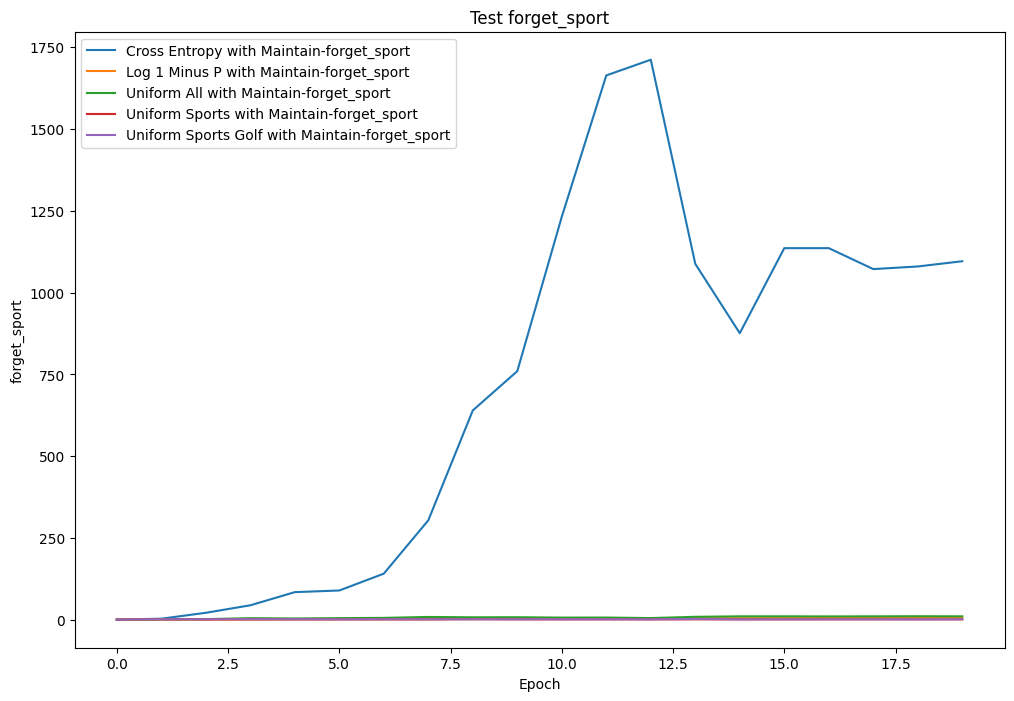

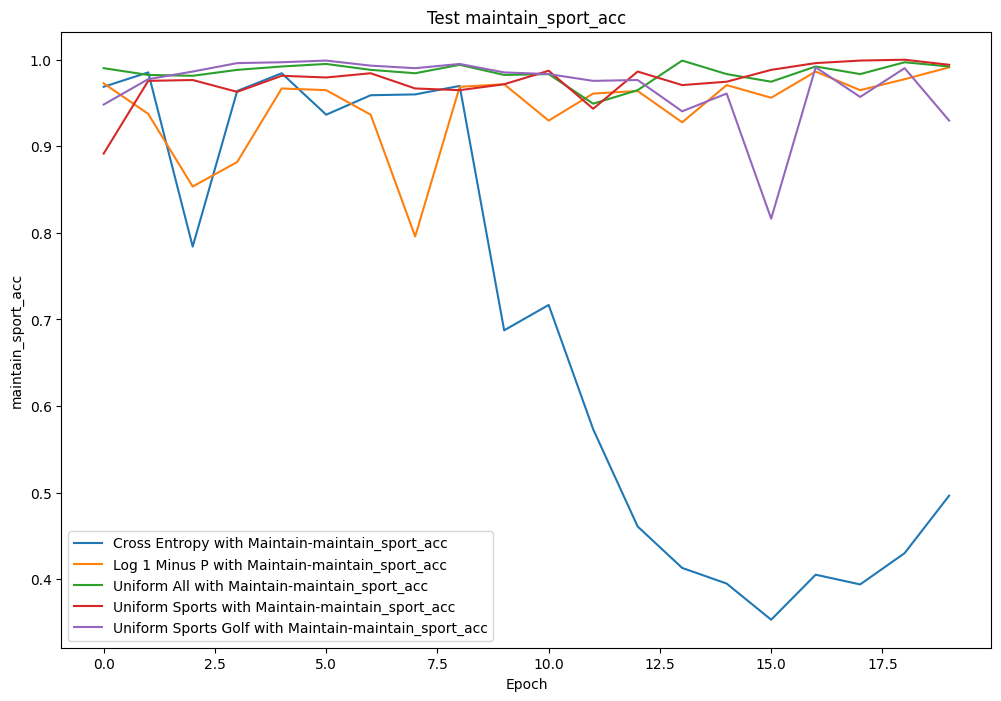

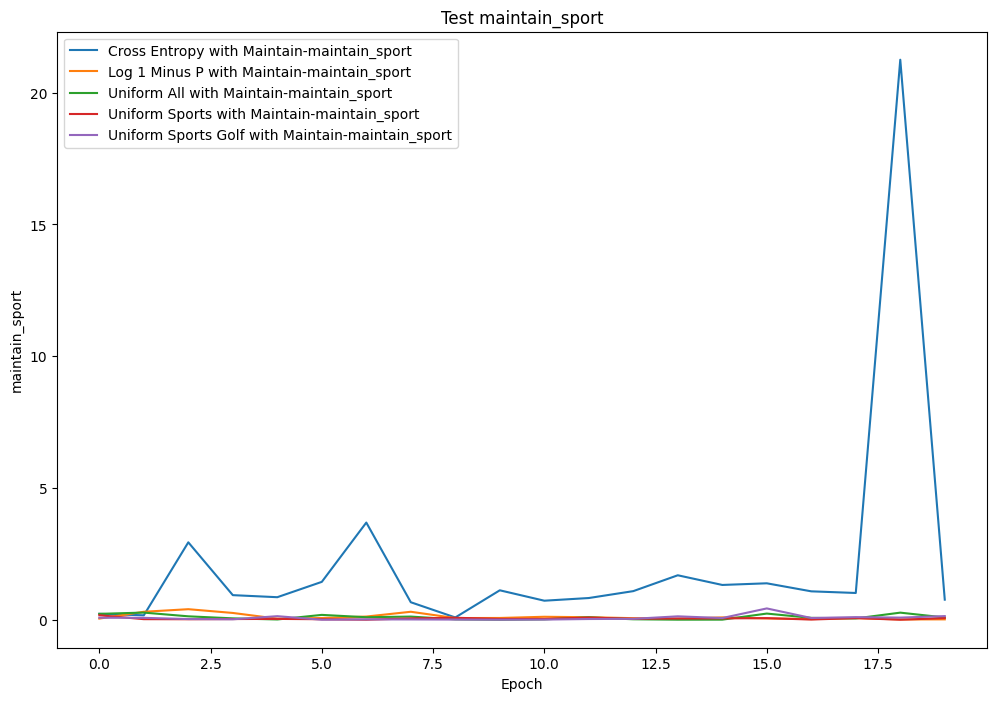

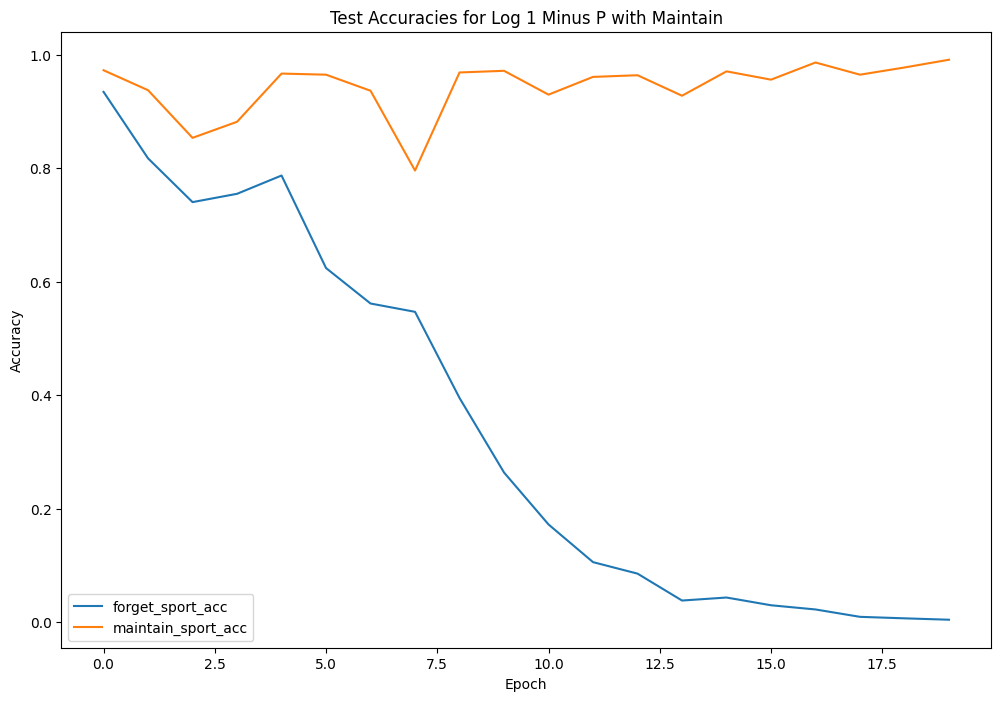

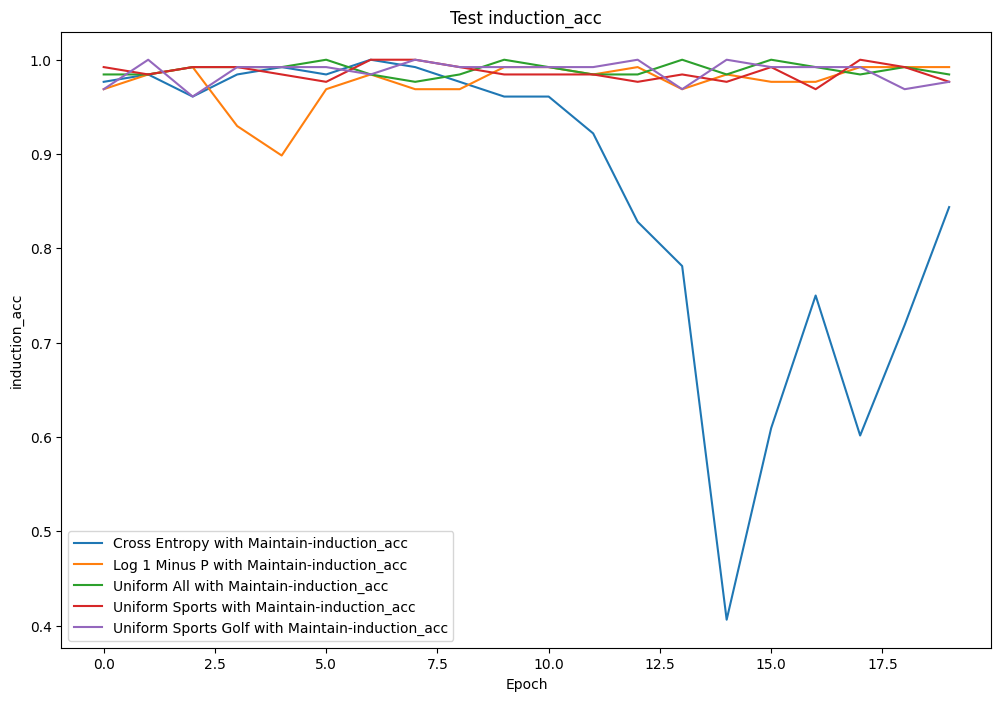

In [17]:
plot_train_metric("pile", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("forget_sport_acc", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("forget_sport", lambda x: "Maintain" in x)
plt.show()

if maintain_sport is not None:
    plot_test_metric("maintain_sport_acc", lambda x: "Maintain" in x)
    plt.show()

    plot_test_metric("maintain_sport", lambda x: "Maintain" in x)
    plt.show()
    
    plot_test_metric("val_sport_acc", lambda x: "Maintain" in x)
    plt.show()

    plot_test_metric("val_sport", lambda x: "Maintain" in x)

    graph_accuracies("Log 1 Minus P with Maintain", include_val=True)
else:
    plot_test_metric("maintain_sport_acc", lambda x: "Maintain" in x)
    plt.show()

    plot_test_metric("maintain_sport", lambda x: "Maintain" in x)
    plt.show()

    graph_accuracies("Log 1 Minus P with Maintain")
# plot_test_metric("val_sport_acc", lambda x: "Maintain" in x)
# plt.show()

# plot_test_metric("val_sport", lambda x: "Maintain" in x)

plot_test_metric("induction_acc", lambda x: "Maintain" in x)
plt.show()

In [39]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
model.cuda()
print(adversarial_sports_eval(model, "qwen", batch_size=eval_batch_size, continuous=False))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'Normal': {'football': 1.0, 'baseball': 0.984375, 'basketball': 0.0}, 'Trivia': {'football': 0.975, 'baseball': 0.9906250000000001, 'basketball': 0.415625}, 'Capitalized': {'football': 1.0, 'baseball': 0.990625, 'basketball': 0.25625000000000003}, 'Dashed': {'football': 0.80625, 'baseball': 1.0, 'basketball': 0.0}}


In [22]:
sports_normal = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device)
model.cuda()
print(sports_normal.get_test_accuracy(model))


train_df: (1252, 8), test_df: (314, 8)
0.3240668773651123


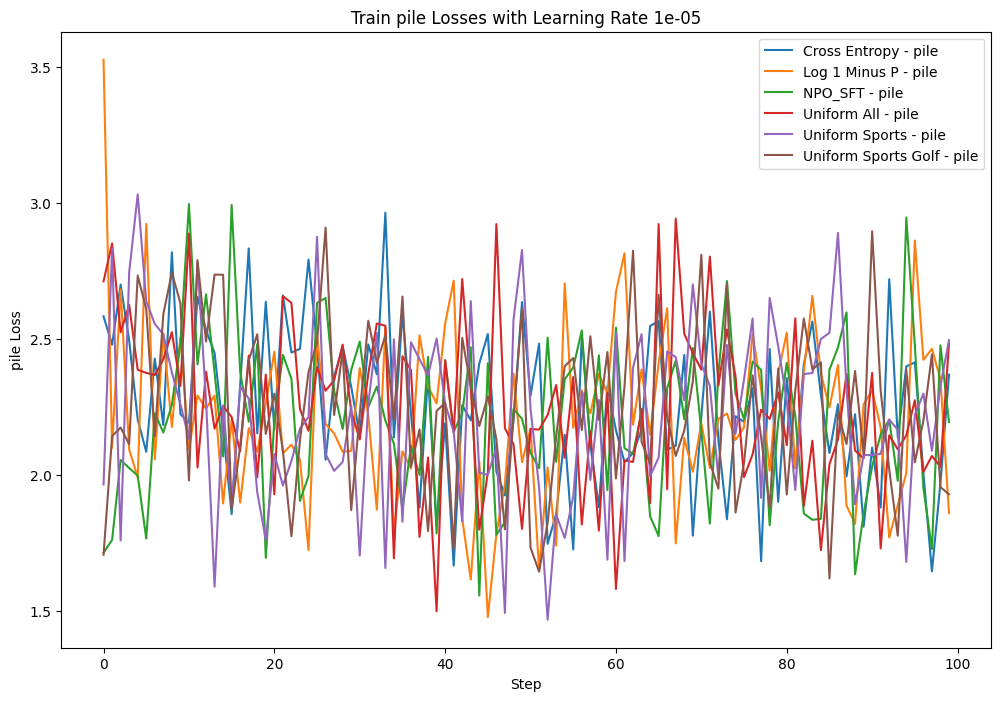

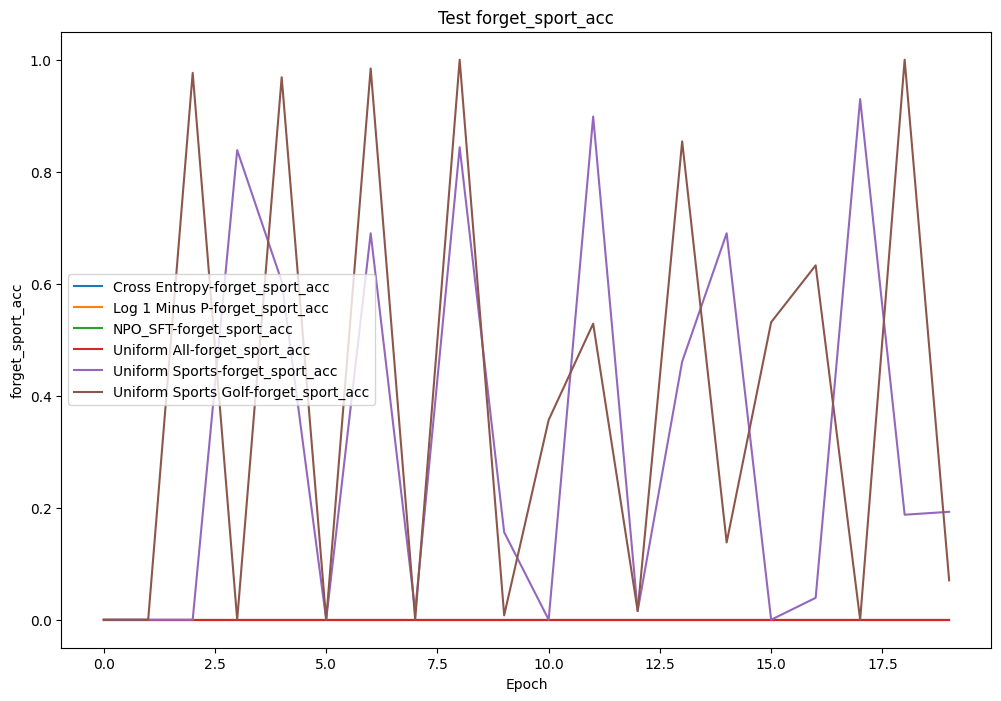

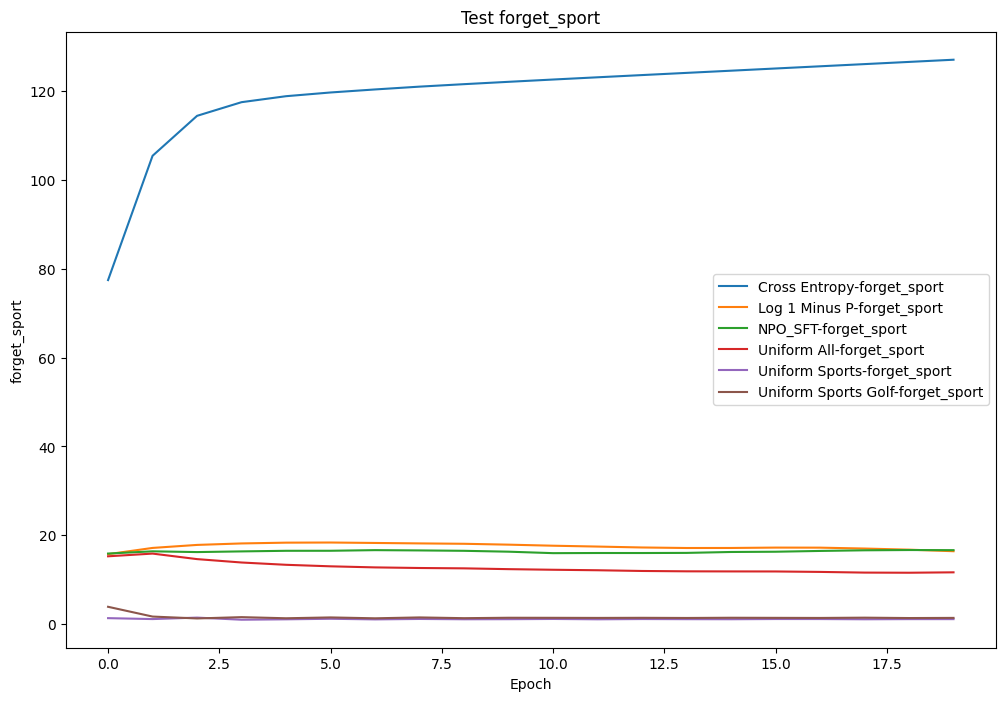

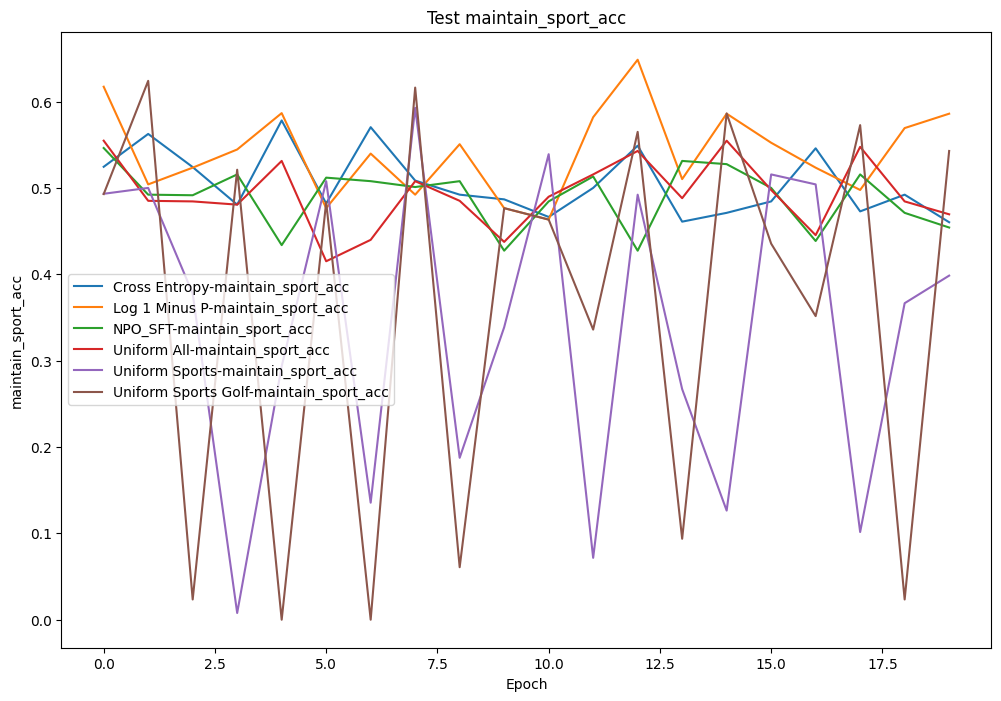

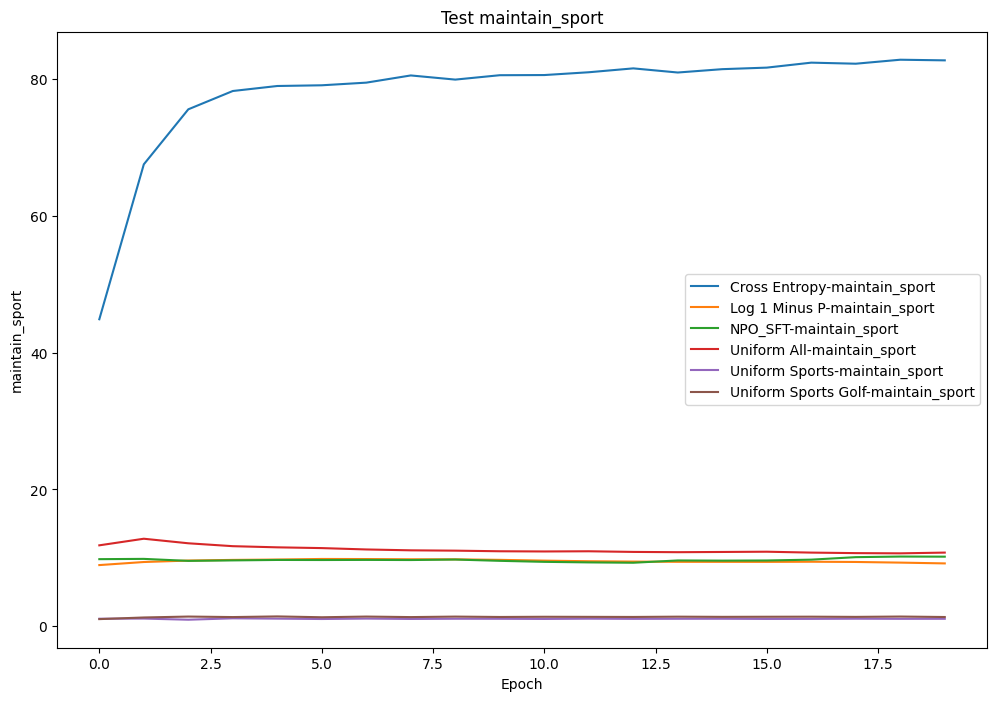

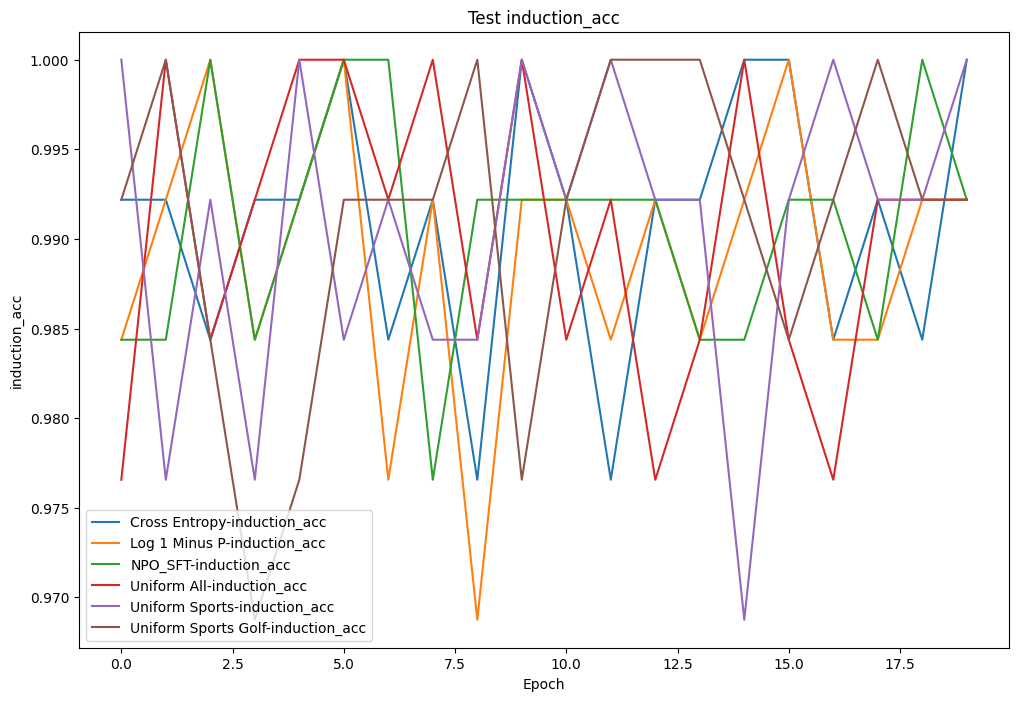

In [10]:
plot_train_metric("pile", lambda x: "Maintain" not in x)
plt.show()

plot_test_metric("forget_sport_acc", lambda x: "Maintain" not in x)
plt.show()

plot_test_metric("forget_sport", lambda x: "Maintain" not in x)
plt.show()

plot_test_metric("maintain_sport_acc", lambda x: "Maintain" not in x)
plt.show()

plot_test_metric("maintain_sport", lambda x: "Maintain" not in x)
plt.show()

plot_test_metric("induction_acc", lambda x: "Maintain" not in x)
plt.show()

## Analyze Losses - GPT2

In [16]:
# import pickle
# with open(f"results/ioi_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses, all_test_losses = pickle.load(f)

# with open("results/ioi_npo_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses_npo, all_test_losses_npo = pickle.load(f)

# # update all_train_losses with items from all_train_losses_npo, all_test_losses with items from all_test_losses_npo
# for loss_name in all_train_losses_npo:
#     all_train_losses[loss_name] = all_train_losses_npo[loss_name]
#     all_test_losses[loss_name] = all_test_losses_npo[loss_name]

# with open("results/ioi_lr=0.001_loss_type_sweep_losses.pkl", "wb") as f:
#     pickle.dump((all_train_losses, all_test_losses), f)

In [33]:
import pickle
lr=1e-3
train_loss_type="induction"
with open(f"results/{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "rb") as f:
    all_train_losses, all_test_losses = pickle.load(f)

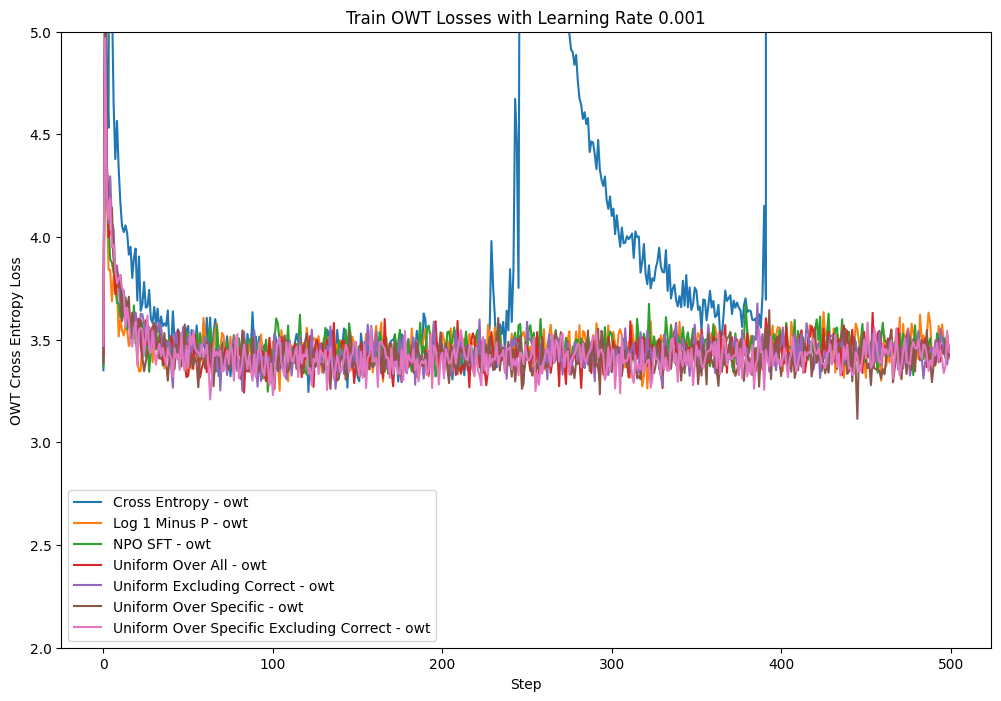

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_train_losses:
    loss_types = all_train_losses[loss_name][0].keys()
    for loss_type in loss_types:
        if "owt" in loss_type:
            plt.plot([x[loss_type] for x in all_train_losses[loss_name]], label=f"{loss_name} - {loss_type}")
plt.ylim(2, 5)
plt.title(f"Train OWT Losses with Learning Rate {lr}")
plt.xlabel("Step")
plt.ylabel("OWT Cross Entropy Loss")
plt.legend()
plt.show()

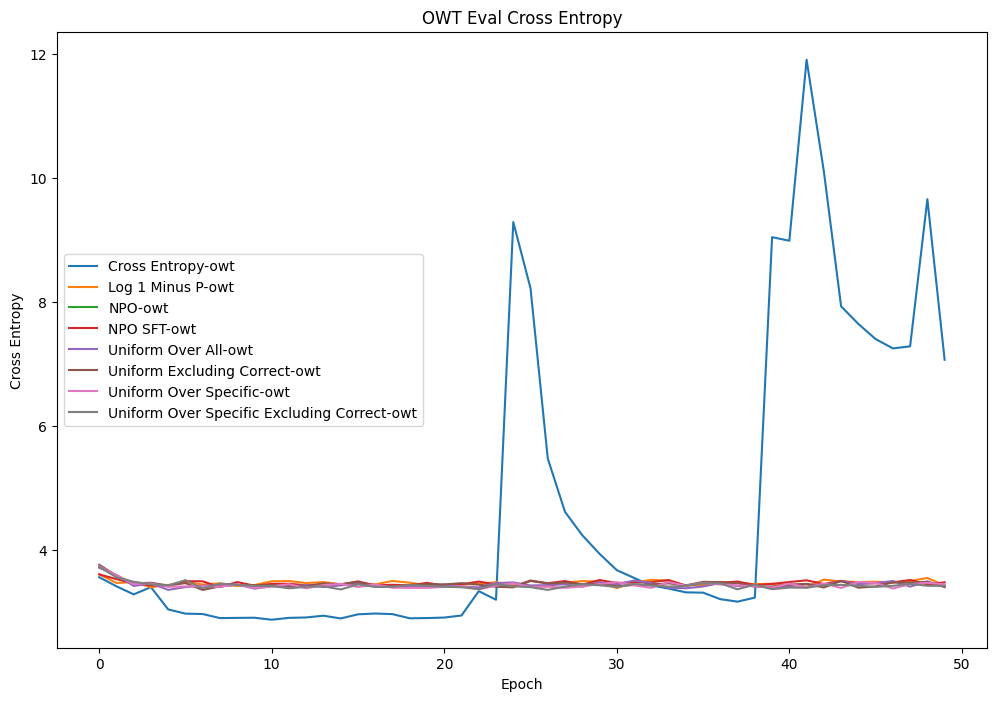

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['owt']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("OWT Eval Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
# only plot y range from 0 to 3
# plt.ylim(-.1, 1.1)

plt.show()

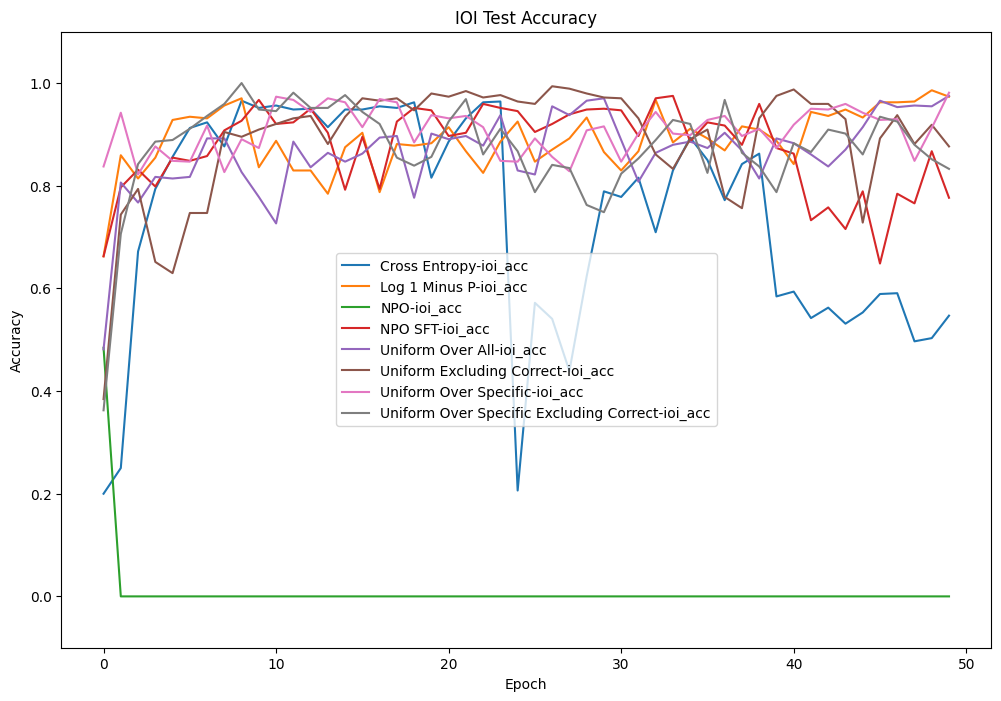

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['ioi_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("IOI Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

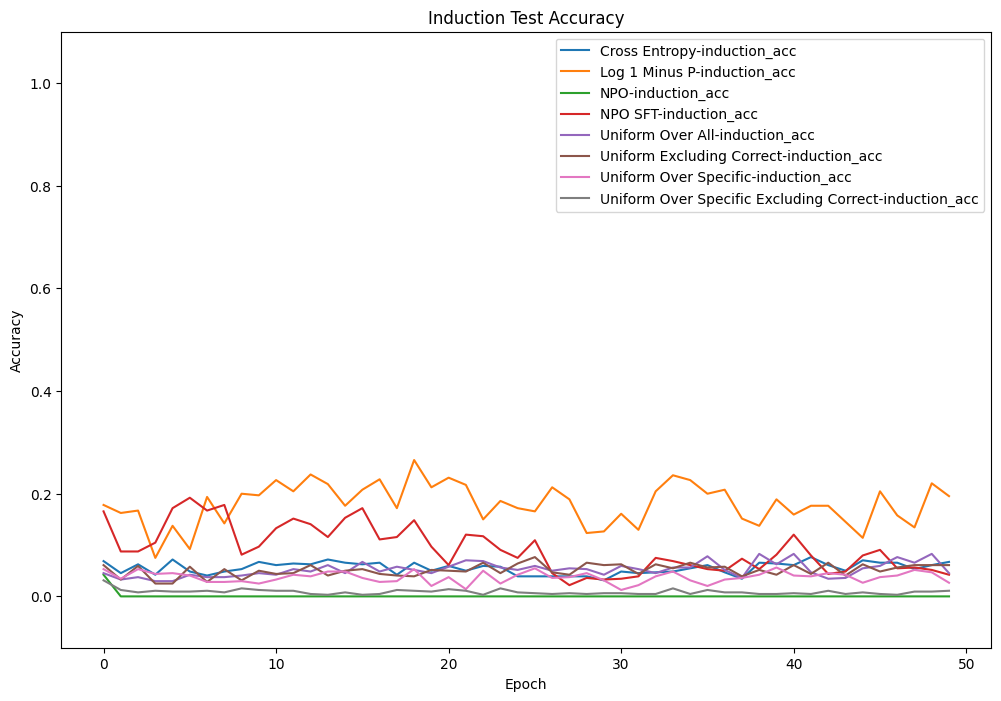

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['induction_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Induction Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

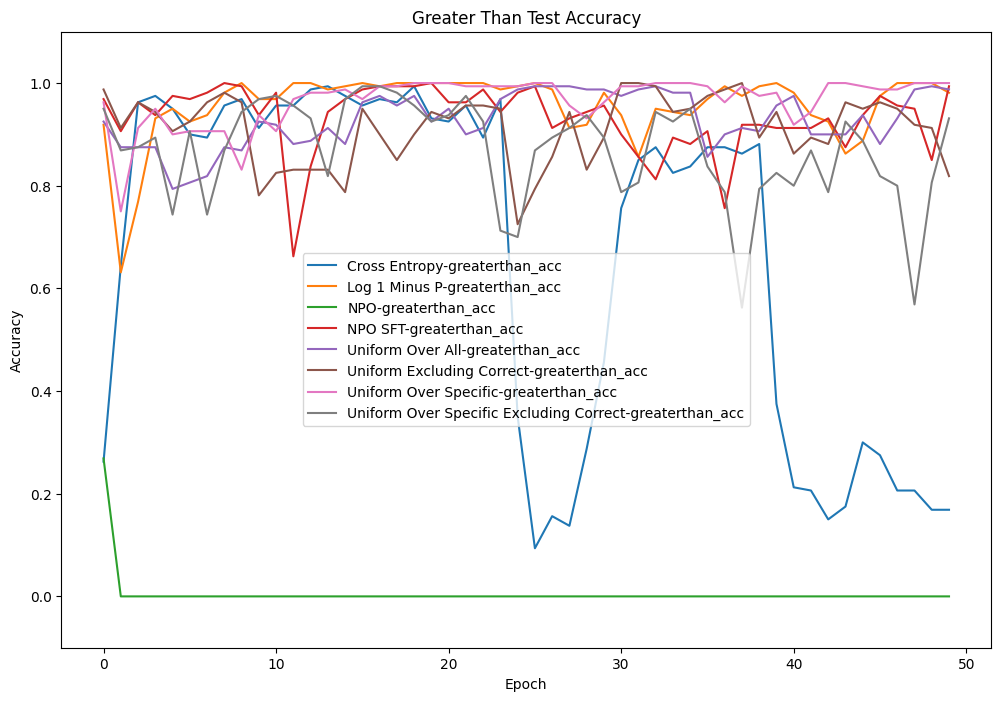

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['greaterthan_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Greater Than Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

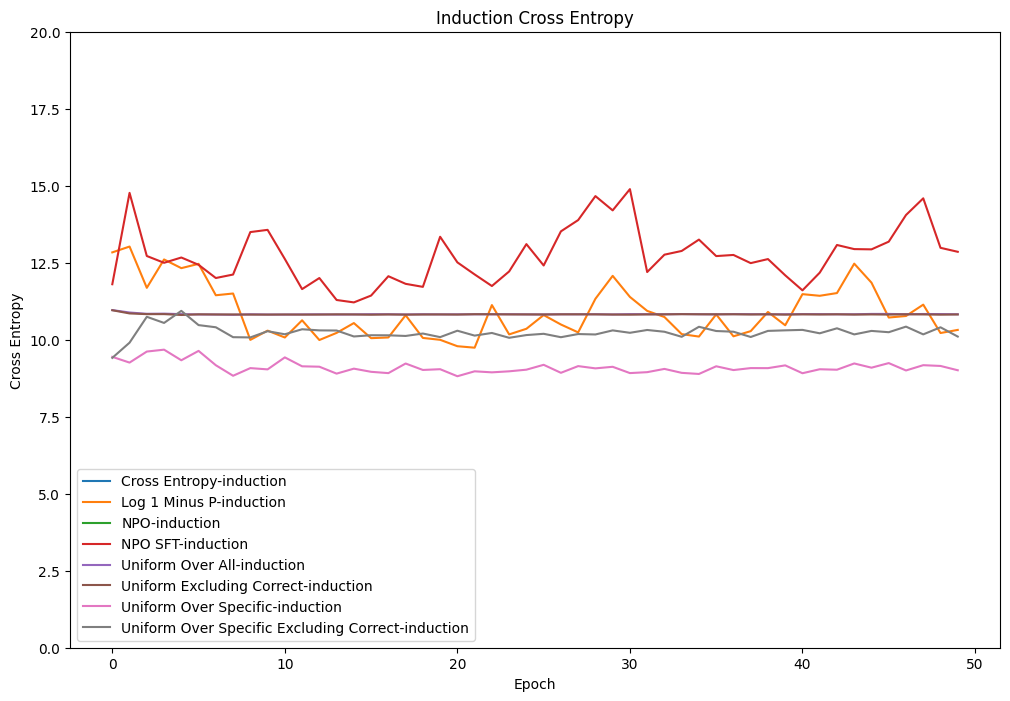

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['induction']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Induction Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
# only plot y range from 0 to 3
plt.ylim(0, 20)

plt.show()

In [ ]:
all_test_losses